# Experiments on the Diabetes dataset

8 input features, all continuous

No known distribution shifts in this dataset, so it is used to mimic the daily model updates.



In [1]:
import time
import os, sys, pickle, json, math, time, multiprocessing, warnings, itertools, random, warnings, gc, ast, subprocess
import copy
from collections import defaultdict, Counter, namedtuple
from math import log
from itertools import product, combinations
from random import choice, choices, sample, seed
from datetime import datetime

import gurobipy
from sklearn.metrics.pairwise import euclidean_distances
from importlib import reload
# Basics
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# Multi-processing
from joblib import Parallel, delayed
from tqdm import tqdm

# sci-kit learn
import sklearn
import sklearn.datasets as datasets
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, make_scorer
from sklearn.metrics import f1_score, precision_score, recall_score, precision_recall_curve
from utilexp import *

pd.options.display.max_columns = 100
pd.options.display.max_rows = 150

import warnings

warnings.filterwarnings('ignore')
from expnns.preprocessor import Preprocessor, min_max_scale

In [2]:
df = pd.read_csv("../datasets/diabetes/diabetes.csv")
df = df.dropna()
display(df)
ordinal_features = {}
discrete_features = {}
continuous_features = list(df.columns)[:-1]
#columns = copy.deepcopy(continuous_features)
CLASS = "Outcome"

# min max scale
min_vals = np.min(df[continuous_features], axis=0)
max_vals = np.max(df[continuous_features], axis=0)
df_mm = min_max_scale(df, continuous_features, min_vals, max_vals)
columns = list(df_mm.columns)
# get X, y
X, y = df_mm.drop(columns=['Outcome']), pd.DataFrame(df_mm['Outcome'])

SPLIT = .2
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=SPLIT, shuffle=True,
                                                    random_state=0)
feat_var_map = {}
for i in range(len(X.columns)):
    feat_var_map[i] = [i]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [3]:
np.random.seed(1)
idx_1 = np.sort(np.random.choice(range(768), 384))
idx_2 = np.array([i for i in range(768) if i not in idx_1])

X1 = pd.DataFrame(data=X.values[idx_1], columns=X.columns)
y1 = pd.DataFrame(data=y.values[idx_1], columns=y.columns)
X2 = pd.DataFrame(data=X.values[idx_2], columns=X.columns)
y2 = pd.DataFrame(data=y.values[idx_2], columns=y.columns)

SPLIT = .2
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, stratify=y1, test_size=SPLIT, shuffle=True,
                                                        random_state=0)


# Train models and Observe model shifts


In [4]:
# Randomdised search + 5-fold cross validation (default)
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

nn = MLPClassifier(learning_rate='adaptive', random_state=0)

# parameters
max_iter_vals = [int(i) for i in np.linspace(1000, 10000, 10)]
hidden_layer_sizes_vals = [(i) for i in range(5, 16)]
batch_size_vals = [8, 16, 32, 64]
learning_rate_init_vals = [0.001, 0.002, 0.005, 0.01, 0.02, 0.05]

#distributions = dict(max_iter=max_iter_vals, hidden_layer_sizes=hidden_layer_sizes_vals)
distributions = dict(hidden_layer_sizes=hidden_layer_sizes_vals,
                     batch_size=batch_size_vals,
                     learning_rate_init=learning_rate_init_vals,
                     max_iter=max_iter_vals, )

#nns = RandomizedSearchCV(nn, distributions, scoring='f1_macro')
#nns = RandomizedSearchCV(nn, distributions, scoring='accuracy')
#search = nns.fit(X, y)
#print(search.best_params_)


{'max_iter': 7000, 'learning_rate_init': 0.01, 'hidden_layer_sizes': 5, 'batch_size': 8}


In [5]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=8, learning_rate_init=0.01, batch_size=8,
                    max_iter=7000, random_state=0)

# 5-fold cross validation
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, f1_score, precision_score

scoring = ['accuracy', 'precision_macro', 'recall_macro', 'f1_macro']
scores = cross_validate(clf, X, y, scoring=scoring)
for name in list(scores.keys()):
    if name == 'fit_time' or name == 'score_time':
        continue
    print("%0.2f %s with a std of %0.2f" % (scores[name].mean(), name, scores[name].std()))

clf = MLPClassifier(learning_rate='adaptive', hidden_layer_sizes=8, learning_rate_init=0.01, batch_size=8,
                    max_iter=7000, random_state=0)

clf.fit(X1_train, y1_train)
resres = clf.predict(X1_test.values)
print('\n', classification_report(y1_test, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))
resres = clf.predict(X1.values)
print('\n', classification_report(y1, resres, target_names=[f'bad credit (0)', f'good credit (1)'], digits=3))


0.76 test_accuracy with a std of 0.04
0.76 test_precision_macro with a std of 0.04
0.72 test_recall_macro with a std of 0.03
0.73 test_f1_macro with a std of 0.04

                  precision    recall  f1-score   support

 bad credit (0)      0.815     0.880     0.846        50
good credit (1)      0.739     0.630     0.680        27

       accuracy                          0.792        77
      macro avg      0.777     0.755     0.763        77
   weighted avg      0.788     0.792     0.788        77


                  precision    recall  f1-score   support

 bad credit (0)      0.849     0.863     0.856       248
good credit (1)      0.742     0.721     0.731       136

       accuracy                          0.812       384
      macro avg      0.796     0.792     0.794       384
   weighted avg      0.811     0.812     0.812       384



In [27]:
from joblib import dump, load

#dump(clf, 'diabetes.joblib')


['diabetes.joblib']

# Experiments: computing counterfactuals

#### Procedures

These procedures are covered by UtilExp class

1. Train M on D1
2. Get delta-min, build M+ and M-: incrementally train M 5 times, using different 10% of D2 each time, then get the maximum inf-distance between the incremented models and M. Construct M+ and M- using delta-min
3. Get M2: incrementally train M on D2
4. Select test instances: randomly select 50 D1 instances to explain, clf(x)=0, desired class=1
5. Report metrics using each baseline

#### Metrics
- Proximity: normalised L1: "Scaling Guarantees for Nearest CEs" page 7
- Sparsity: L0
- Validity-delta: percentage of test instances that 1) have counterfactuals valid on m1, 2) counterfactuals valid on M+ and M- under delta_min
- Validity-m2: percentage of test instances that 1) have counterfactual(s), 2) these counterfactual(s) are all valid on both m1 and m2
- LOF: average LOF score

In [29]:
from joblib import dump, load
import gurobipy
clf = load("diabetes.joblib")
from utilexp import *
gurobipy.setParam("FeasibilityTol", 1e-09)
gurobipy.setParam("OptimalityTol", 1e-09)
gurobipy.setParam("IntFeasTol", 1e-05)


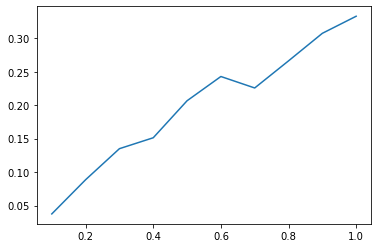

In [30]:
gaps = np.arange(0.1, 1.01, 0.1)
deltas = []
clfs = []
for a, i in enumerate(gaps):
    clfs.append(copy.deepcopy(clf))
    util_exp = UtilExp(clfs[a], X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map,
                   num_test_instances=1000, gap=i)
    deltas.append(util_exp.delta_min)
plt.plot(gaps, deltas)

In [31]:
util_exp = UtilExp(clf, X1, y1, X2, y2, columns, ordinal_features, discrete_features, continuous_features, feat_var_map, num_test_instances=500, gap=0.25)
print(util_exp.delta_max)
print(util_exp.delta_min)

0.34579062177846387
0.10583956465260402


In [32]:
m2 = copy.deepcopy(clf)
m2.partial_fit(X2, y2)
util_exp.Mmax = m2

In [33]:
valids = util_exp.verify_soundness()
print(len(valids))

percentage of sound model changes: 0.27380952380952384
69


In [34]:
valids = util_exp.verify_soundness(update_test_instances=True)

percentage of sound model changes: 0.27380952380952384
test instances updated to sound (x, Delta) pairs, length: 50


In [23]:
# OURS-ROBUST
ours_robust_ces = util_exp.run_ours_robust()
util_exp.evaluate_ces(ours_robust_ces)

50it [00:11,  4.37it/s]


total computation time in s: 11.450013637542725
found: 1.0
average normalised L1: 0.21184376391535953
average normalised L0: 0.415
average lof score: -0.48
counterfactual validity: 1.0
delta validity: 1.0
m2 validity: 1.0


In [75]:
#np.save("./results/diab-milp-r.npy", ours_robust_ces)
#ours_robust_ces = list(np.load("./results/diab-milp-r.npy"))

In [74]:
# OURS-NON-ROBUST
ours_non_robust_ces = util_exp.run_ours_non_robust()
util_exp.evaluate_ces(ours_non_robust_ces)

50it [00:00, 199.20it/s]


total computation time in s: 0.2520017623901367
found: 1.0
average normalised L1: 0.04859600863440344
average normalised L0: 0.2475
average lof score: 0.96
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.0


In [76]:
#np.save("./results/diab-milp.npy", ours_non_robust_ces)
#ours_non_robust_ces = list(np.load("./results/diab-milp.npy"))

In [22]:
# ROAR
roar_ces = util_exp.run_ROAR(labels=(1,))
util_exp.evaluate_ces(roar_ces)

0it [00:00, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  3.10it/s]

0it [00:00, ?it/s]
1it [00:00,  3.12it/s]

0it [00:00, ?it/s]
1it [00:00,  3.22it/s]

0it [00:00, ?it/s]
1it [00:00,  2.91it/s]

0it [00:00, ?it/s]
1it [00:00,  3.31it/s]

0it [00:00, ?it/s]
1it [00:00,  4.85it/s]

0it [00:00, ?it/s]
1it [00:00,  5.24it/s]

0it [00:00, ?it/s]
1it [00:00,  5.99it/s]
1it [00:02,  2.37s/it]
0it [00:00, ?it/s]
1it [00:00,  3.76it/s]

0it [00:00, ?it/s]
1it [00:00,  3.80it/s]

0it [00:00, ?it/s]
1it [00:00,  3.70it/s]

0it [00:00, ?it/s]
1it [00:00,  3.85it/s]

0it [00:00, ?it/s]
1it [00:00,  4.15it/s]

0it [00:00, ?it/s]
1it [00:00,  6.85it/s]
2it [00:04,  1.97s/it]
0it [00:00, ?it/s]
1it [00:00,  3.12it/s]

0it [00:00, ?it/s]
1it [00:00,  3.10it/s]

0it [00:00, ?it/s]
1it [00:00,  3.27it/s]

0it [00:00, ?it/s]
1it [00:00,  3.32it/s]

0it [00:00, ?it/s]
1it [00:00,  3.29it/s]

0it [00:00, ?it/s]
1it [00:00,  4.72it/s]

0it [00:00, ?it/s]
1it [00:00,  4.81it/s]

0it [00:00, ?it/s]
1it [00:00,  5.

total computation time in s: 94.80147433280945
found: 1.0
average normalised L1: 0.07763249310677958
average normalised L0: 0.9024390243902439
average lof score: 0.9512195121951219
counterfactual validity: 0.82
delta validity: 0.0
m2 validity: 0.14


In [77]:
#np.save("./results/diab-roar.npy", roar_ces)
#roar_ces = list(np.load("./results/diab-roar.npy"))

In [25]:
# PROTOTYPES
proto_ces = util_exp.run_proto(kap=0.05)
util_exp.evaluate_ces(proto_ces)

No encoder specified. Using k-d trees to represent class prototypes.
50it [12:48, 15.36s/it]


total computation time in s: 768.1049990653992
found: 1.0
average normalised L1: 0.06319319890463919
average normalised L0: 0.3675
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.18


In [78]:
#np.save("./results/diab-proto.npy", proto_ces)
#proto_ces = list(np.load("./results/diab-proto.npy"))

In [102]:
# PROTOTYPES-robustness-boosted
proto_ces_robust = util_exp.run_proto_robust(kap=0.05)
util_exp.evaluate_ces(proto_ces_robust)

0it [00:00, ?it/s]No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No counterfactual found!
1it [02:00, 120.22s/it]No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees to represent class prototypes.
No encoder specified. Using k-d trees

total computation time in s: 5687.862963676453
found: 1.0
average normalised L1: 0.10386988123084012
average normalised L0: 0.4975
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.02
m2 validity: 0.96


In [104]:
np.save("./results/diab-proto-r.npy", proto_ces_robust)
#proto_ces_robust = list(np.load("./results/diab-proto-r.npy"))

In [44]:
# WACHTER CF
wachter_ces = util_exp.run_wachter(target_proba=0.56, max_lam_steps=10)
util_exp.evaluate_ces(wachter_ces)


50it [03:47,  4.56s/it]


total computation time in s: 227.9310004711151
found: 1.0
average normalised L1: 0.05065667188383727
average normalised L0: 0.865
average lof score: 0.96
counterfactual validity: 1.0
delta validity: 0.0
m2 validity: 0.0


In [79]:
#np.save("./results/diab-wachter.npy", wachter_ces)
#wachter_ces = list(np.load("./results/diab-wachter.npy"))

In [103]:
# WACHTER CF - robustness-boosted
wachter_ces_rob = util_exp.run_wachter_robust(target_proba=0.55)
util_exp.evaluate_ces(wachter_ces_rob)


50it [3:28:55, 250.72s/it]


total computation time in s: 12535.937328338623
found: 1.0
average normalised L1: 0.12207514727366103
average normalised L0: 0.91
average lof score: 1.0
counterfactual validity: 1.0
delta validity: 0.2
m2 validity: 1.0


In [105]:
np.save("./results/diab-wachter-r.npy", wachter_ces_rob)
#wachter_ces_rob = list(np.load("./results/diab-wachter-r.npy"))

In [36]:
delta = util_exp.delta_min
print(np.arange(delta/10, delta*1.01, delta/10))
plot_x = np.arange(0.1, 1.01, 0.1)
print(delta)
print(plot_x)

[0.01058396 0.02116791 0.03175187 0.04233583 0.05291978 0.06350374
 0.0740877  0.08467165 0.09525561 0.10583956]
0.10583956465260402
[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1. ]


In [37]:
plot_x = [str(i) + "*$\delta$" for i in np.round(np.arange(0.0, 1.00001, 0.1), 1)]
print(plot_x)
plot_x_num = np.round(np.arange(0.0, 1.00001, 0.1), 1)

['0.0*$\\delta$', '0.1*$\\delta$', '0.2*$\\delta$', '0.3*$\\delta$', '0.4*$\\delta$', '0.5*$\\delta$', '0.6*$\\delta$', '0.7*$\\delta$', '0.8*$\\delta$', '0.9*$\\delta$', '1.0*$\\delta$']


In [38]:
def evaluate_ces_validity_plot(test_instances, ces, target_delta=0.05):
    deltas = np.concatenate((np.array([0]),np.arange(target_delta/10, target_delta*1.01, target_delta/10)))
    delta_vals = []
    for delta in deltas:
        delta_val = 0
        nodes = build_inn_nodes(util_exp.clf, util_exp.num_layers)
        weights, biases = build_inn_weights_biases(util_exp.clf, util_exp.num_layers, delta, nodes)
        inn_delta = Inn(util_exp.num_layers, delta, nodes, weights, biases)
        for i, x in enumerate(test_instances):
            if ces[i] is None:
                continue
            y_prime = 1 if util_exp.clf.predict(x.reshape(1, -1))[0] == 0 else 0
            this_solver = OptSolver(util_exp.dataset, inn_delta, y_prime, x, mode=1, M=10000, x_prime=ces[i])
            if this_solver.compute_inn_bounds()[0] == 1:
                delta_val += 1
        delta_vals.append(delta_val / len(test_instances))
    return delta_vals


In [106]:
delta_vals_roar = evaluate_ces_validity_plot(util_exp.test_instances, roar_ces, target_delta=util_exp.delta_min)
delta_vals_ours_rob = evaluate_ces_validity_plot(util_exp.test_instances, ours_robust_ces,
                                                     target_delta=util_exp.delta_min)
delta_vals_ours_non_rob = evaluate_ces_validity_plot(util_exp.test_instances, ours_non_robust_ces,
                                                     target_delta=util_exp.delta_min)
delta_vals_wachter = evaluate_ces_validity_plot(util_exp.test_instances, wachter_ces, target_delta=util_exp.delta_min)
delta_vals_wachter_rob = evaluate_ces_validity_plot(util_exp.test_instances, wachter_ces_rob, target_delta=util_exp.delta_min)
delta_vals_proto = evaluate_ces_validity_plot(util_exp.test_instances, proto_ces, target_delta=util_exp.delta_min)
delta_vals_proto_rob = evaluate_ces_validity_plot(util_exp.test_instances, proto_ces_robust, target_delta=util_exp.delta_min)

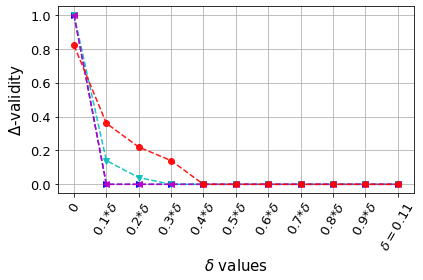

In [109]:
fig, ax = plt.subplots()
ax.plot(plot_x_num, delta_vals_wachter, "b>--", label="WACHTER", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_wachter_rob, "b>-", label="WACHTER-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_proto, "cv--", label="PROTO", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_proto_rob, "cv-", label="PROTO-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_ours_non_rob, "m<--", label="MILP", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_ours_rob, "m<-", label="MILP-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_roar, "ro--", label="ROAR", alpha=0.9)
ax.set_xticks(np.arange(0., 1.01, 0.1))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = plot_x[i]
    if i == len(labels) - 1:
        labels[i] = "$\delta=$" + str(np.round(util_exp.delta_min, 2))
    if i == 0:
        labels[i] = str(0)
ax.set_xticklabels(labels, fontsize=13)
ylabels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels, fontsize=13)
ax.grid()
#ax.legend()
plt.xticks(rotation=60)
ax.set_ylabel("$\Delta$-validity", fontsize=15)
ax.set_xlabel("$\delta$ values", fontsize=15)
fig.tight_layout()
fig.savefig("./plots/delta-val-diabetes.png", dpi=300)

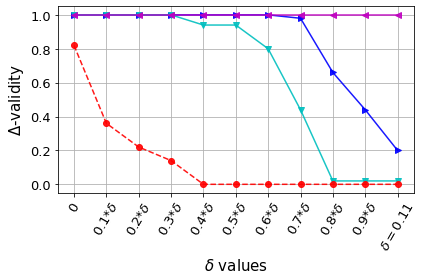

In [110]:
fig, ax = plt.subplots()
#ax.plot(plot_x_num, delta_vals_wachter, "b>--", label="WACHTER", alpha=0.9)
ax.plot(plot_x_num, delta_vals_wachter_rob, "b>-", label="WACHTER-R", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_proto, "cv--", label="PROTO", alpha=0.9)
ax.plot(plot_x_num, delta_vals_proto_rob, "cv-", label="PROTO-R", alpha=0.9)
#ax.plot(plot_x_num, delta_vals_ours_non_rob, "m<--", label="MILP", alpha=0.9)
ax.plot(plot_x_num, delta_vals_ours_rob, "m<-", label="MILP-R", alpha=0.9)
ax.plot(plot_x_num, delta_vals_roar, "ro--", label="ROAR", alpha=0.9)
ax.set_xticks(np.arange(0., 1.01, 0.1))
labels = [item.get_text() for item in ax.get_xticklabels()]
for i in range(len(labels)):
    labels[i] = plot_x[i]
    if i == len(labels) - 1:
        labels[i] = "$\delta=$" + str(np.round(util_exp.delta_min, 2))
    if i == 0:
        labels[i] = str(0)
ax.set_xticklabels(labels, fontsize=13)
ylabels = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
ax.set_yticks(ylabels)
ax.set_yticklabels(ylabels, fontsize=13)
ax.grid()
#ax.legend()
plt.xticks(rotation=60)
ax.set_ylabel("$\Delta$-validity", fontsize=15)
ax.set_xlabel("$\delta$ values", fontsize=15)
fig.tight_layout()
fig.savefig("./plots/robust-delta-val-diabetes.png", dpi=300)
